## Installation of **Libraries**

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from six import BytesIO
from PIL import Image
import torchvision.transforms as T
%matplotlib inline

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3636, done.
remote: Counting objects: 100% (3636/3636), done.
remote: Compressing objects: 100% (3035/3035), done.
remote: Total 3636 (delta 960), reused 1539 (delta 547), pack-reused 0
Receiving objects: 100% (3636/3636), 47.37 MiB | 31.64 MiB/s, done.
Resolving deltas: 100% (960/960), done.


In [3]:
!sudo apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [4]:
cd models/research/

/content/models/research


In [5]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
import matplotlib.pyplot as plt
%matplotlib inline

# **Calling tensorflow hub models**

In [7]:
model_url_1 = "https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1"
model_url_2 = "https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1"

hub_model_1 = hub.load(model_url_1)
hub_model_2 = hub.load(model_url_2)

In [8]:
def load_image(path):
  image_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)

In [10]:
img_tensor = load_image('/content/image2.jpg')

In [175]:
r1 = hub_model_1(img_tensor)
r2 = hub_model_2(img_tensor)

In [176]:
r1_result = {key:value.numpy() for key,value in r1.items()}
r2_result = {key:value.numpy() for key,value in r2.items()}

In [177]:
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Visualizing both models output

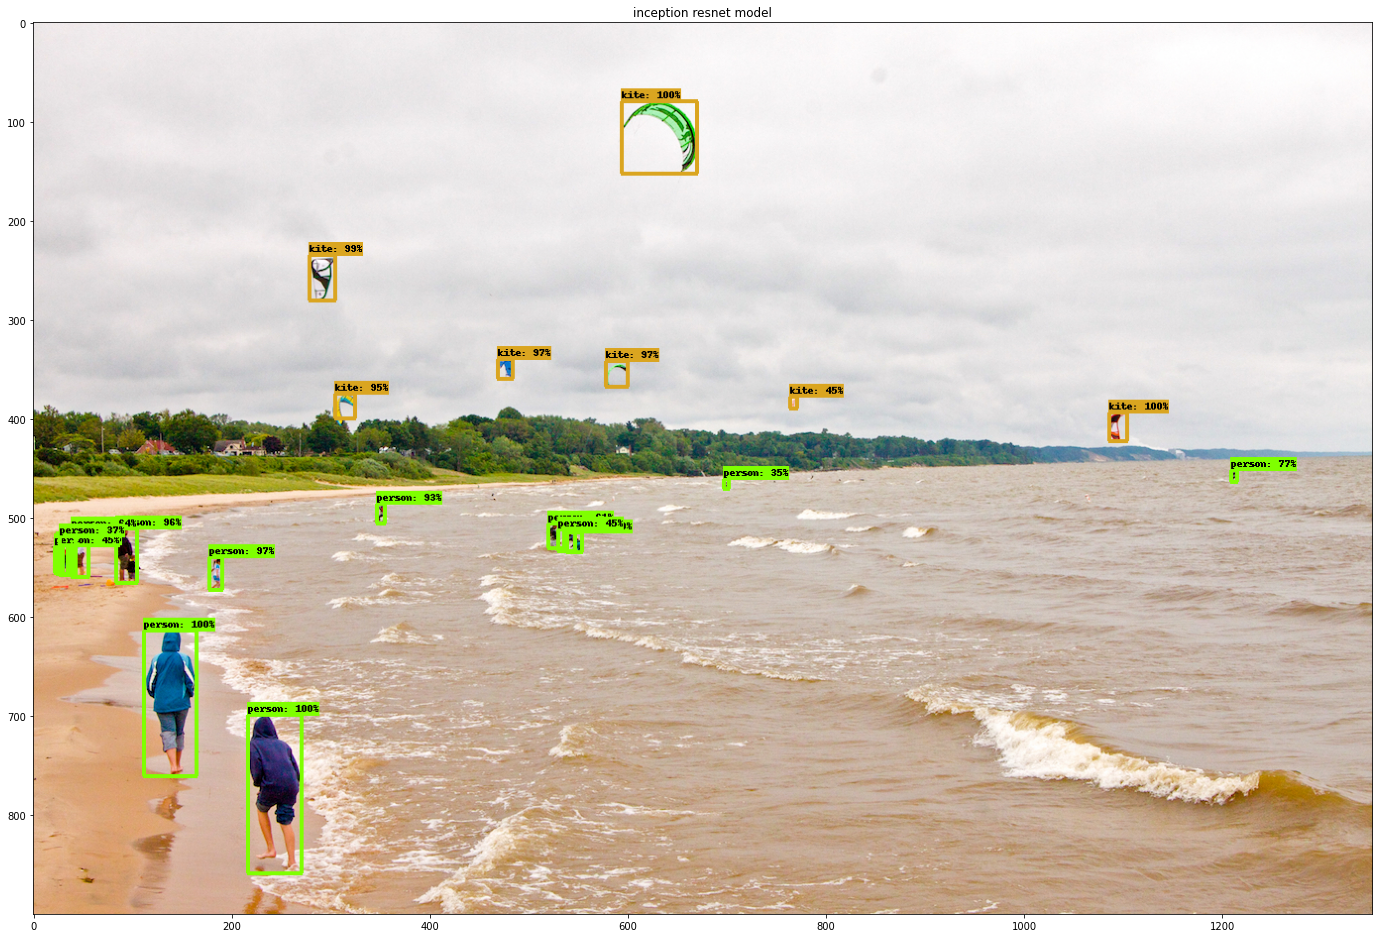

In [178]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      r1_result['detection_boxes'][0],
      (r1_result['detection_classes'][0] + label_id_offset).astype(int),
      r1_result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.title('inception resnet model')
plt.show()

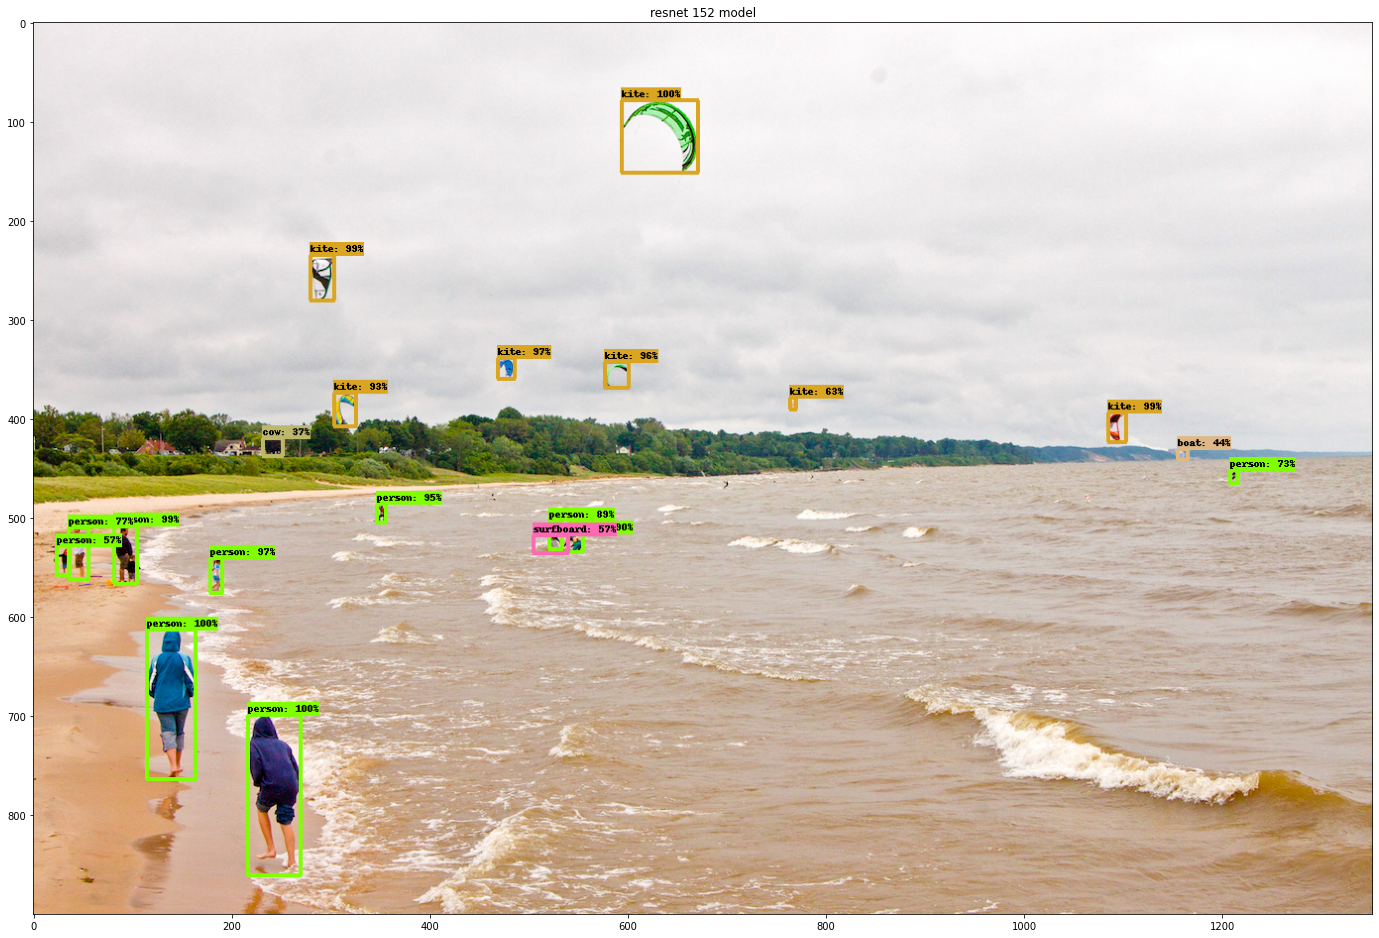

In [179]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      r2_result['detection_boxes'][0],
      (r2_result['detection_classes'][0] + label_id_offset).astype(int),
      r2_result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.title('resnet 152 model')
plt.show()

# Combining both models output to a single dictionary using dictionary comprehension

In [181]:
r3 = {key:np.hstack([r1_result[key],r2_result[key]]) for key in r1_result.keys() if key=='detection_boxes'}

In [182]:
r4 = {key:np.append(r1_result[key],r2_result[key]) for key in r1_result.keys() if key in ['detection_scores','detection_classes']}

In [183]:
r3.update(r4)

# Code from internet for finding the best boxes using NMS

In [247]:
def IOU(box1, box2):
	x1, y1, x2, y2 = box1
	x3, y3, x4, y4 = box2
	x_inter1 = max(x1, x3)
	y_inter1 = max(y1, y3)
	x_inter2 = min(x2, x4)
	y_inter2 = min(y2, y4)
	width_inter = abs(x_inter2 - x_inter1)
	height_inter = abs(y_inter2 - y_inter1)
	area_inter = width_inter * height_inter
	width_box1 = abs(x2 - x1)
	height_box1 = abs(y2 - y1)
	width_box2 = abs(x4 - x3)
	height_box2 = abs(y4 - y3)
	area_box1 = width_box1 * height_box1
	area_box2 = width_box2 * height_box2
	area_union = area_box1 + area_box2 - area_inter
	iou = area_inter / area_union
	return iou
def nms(boxes, conf_threshold=0.75, iou_threshold=0.5):
  bbox_list_thresholded = []
  bbox_list_new = []
  boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[5])
  for box in boxes_sorted:
    if box[5] > conf_threshold:
        bbox_list_thresholded.append(box)
    else:
        pass
  while len(bbox_list_thresholded) > 0:
    current_box = bbox_list_thresholded.pop(0)
    
    bbox_list_new.append(current_box)
  for box in bbox_list_thresholded:
    if current_box[4] == box[4]:
      iou = IOU(current_box[:4], box[:4])
    if iou > iou_threshold:
      bbox_list_thresholded.remove(box)
  return bbox_list_new

# Preprocessing of our data to set as per the above NMS function

In [248]:
box = []
for x in range(0,len(r3['detection_boxes'][0])):
  b = []
  b.append(r3['detection_boxes'][0].tolist()[x])
  b[0].append(r3['detection_classes'].tolist()[x])
  b[0].append(r3['detection_scores'][x])
  box.append(b[0])

In [249]:
nms_box = nms(box)

# Making the output from NMS to finally set in dictionary to visualize the results

In [250]:
final_d = {}
b = []
s=[]
c =[]
for i in nms_box:
  
  b.append(i[:4])
  c.append(i[4])
  s.append(i[5])
final_d['detection_boxes'] = np.array([b])
final_d['detection_classes'] = np.array(c)
final_d['detection_scores'] = np.array(s)

# Visualizing the output of the model after NMS layer

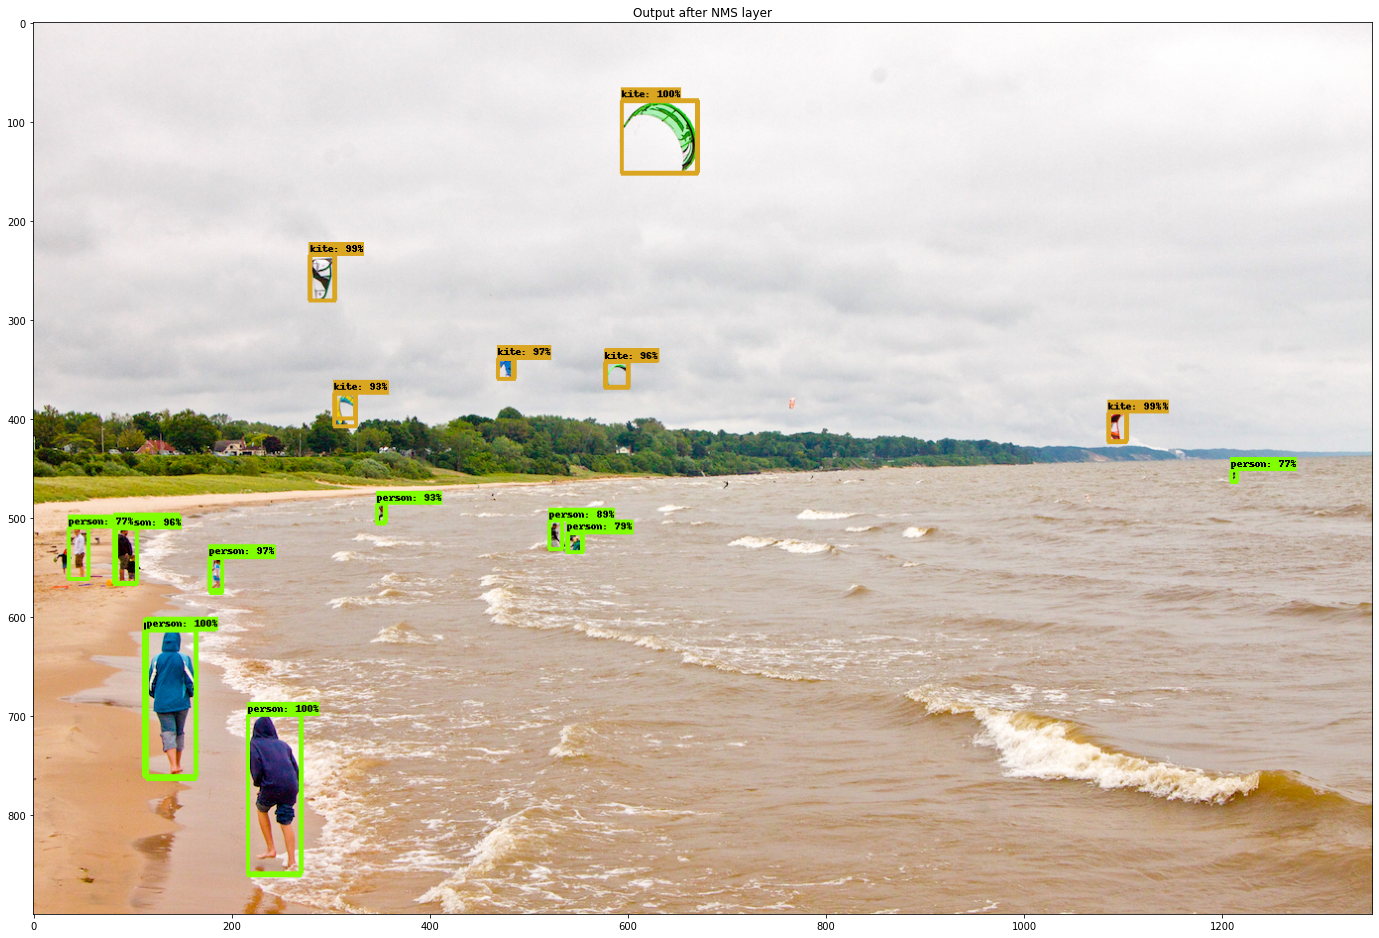

In [251]:
label_id_offset = 0
image_np_with_detections = img_tensor.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      final_d['detection_boxes'][0],
      (final_d['detection_classes'] + label_id_offset).astype(int),
      final_d['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.45,
      agnostic_mode=False)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.title('Output after NMS layer')
plt.show()